# Controlled Text Generation Using Transformers

This project was a part of the course DIT245: Machine learning for natural language processing.
Made by Karl Griphammar & Kieron Hayes, 2021

The dataset used in this notebook is the [AG News Classification Dataset](https://www.kaggle.com/amananandrai/ag-news-classification-dataset), and comes originally from http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html. From the description:


> The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600



In [2]:
# Importing libraries:

# For reading the file
from pathlib import Path
import pandas as pd

# For implementing the transformer-based model, and for setting up the training:
from torch.utils.data import Dataset
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# For implementing the pre-trained model and tokenizer:
from transformers import AutoTokenizer

# For setting up the LDA model:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Utilities:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import ceil
from sklearn.model_selection import train_test_split
import copy
import time
from random import randint

# Setting the torch seed manually for reproducing results:
manualSeed = 42
torch.manual_seed(manualSeed)

In [4]:
# Just to show how the dataset is structured. This is not used in the code later on.
full_set = pd.read_csv('train.csv')
full_set.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Creating a custom dataset class used in the models:

In [5]:
class NewsArticles(Dataset):  
    def __init__(self, topics=[2,4], tokenizer=None, max_length=64):

        self.tokenizer = tokenizer
        self.topics = topics
        self.max_length = max_length
        self.input_ids = []
        self.attention_mask = []
        self.text_articles = []
        self.encode_articles()
        
    def article_parser(self,row):
        '''
        A method for preprocessing the text in the pandas series containing
        the news summaries. In the original set, the news summary is structured
        as '[News source] - [News summary]'. E.g. 'AP - A company founded by...'.
        What this function does is to remove the prefix, leaving only the summary.
        E.g. 'AP - A company founded by...' -> 'A company founded by...'.

        '''

        full_text = row.Description
        #My suggestion for a new version:
        text_start = full_text[:40]
        if '- ' in text_start:
            return full_text[full_text.find('- ')+2:]
        elif ' : ' in text_start:
            return full_text[full_text.find(' : ')+3:]
        elif '--' in text_start:
            return full_text[full_text.find('--')+2:]
        else:
            return full_text
    
    def encode_articles(self):
        '''
        The main method of the class. Reads the dataset, preprocess the texts
        and tokenize it. The tokenized news summaries are stored in input_ids,
        and the raw text is stored in text_articles.

        '''
        
        # Reading the csv-file:
        train = pd.read_csv('train.csv')

        # There are four topics in the dataset, labled with integers as following
        # 1: World, 2: Sports, 3: Business, 4: Sci/tech
        # For simplicity, we only allow two topics in this model:
        ta, tb = self.topics
        topic_set = train[(train['Class Index'] == ta) | (train['Class Index'] == tb)]

        # Temporary set of parsed articles:
        temp_set = topic_set.apply(self.article_parser,axis=1)
        
        # Saving to list:
        self.text_articles = temp_set.to_list()
        
        self.tokenizer.pad_token = self.tokenizer.eos_token
        encoded_articles = self.tokenizer(self.text_articles,
                                          padding=True,
                                          truncation=True,
                                          max_length=self.max_length,
                                          return_tensors='pt')
        
        self.input_ids = encoded_articles['input_ids']
        self.attention_mask = encoded_articles['attention_mask']
    
    def decode_article(self, idx):
        '''
        Method for decoding a tokenized article.
        '''
        return self.tokenizer.decode(self.input_ids[idx])
    
    def get_text(self, idx):
        '''
        Method for reading a raw text.
        '''
        return self.text_articles[idx]

    def get_all_texts(self):
        '''
        Method for accessing the list of raw text articles.
        '''
        return self.text_articles
        
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx]
    

In [25]:
# For example, here is one sports article from the dataset:
display(news_dataset.get_text(2))

# ...And the encoded version:
display(news_dataset[2])

# Which can be decoded if we want so:
display(news_dataset.decode_article(2))


'America Online on Thursday said it\\plans to sell a low-priced PC targeting low-income and minority\\households who agree to sign up for a year of dialup Internet\\service.'

tensor([18165,  7467,   319,  3635,   531,   340,    59,   489,   504,   284,
         3677,   257,  1877,    12, 30883,  4217, 10822,  1877,    12, 12519,
          290,  9137,    59,  4803,  2946,    82,   508,  4236,   284,  1051,
          510,   329,   257,   614,   286,  5980,   929,  4455,    59, 15271,
           13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256])

'America Online on Thursday said it\\plans to sell a low-priced PC targeting low-income and minority\\households who agree to sign up for a year of dialup Internet\\service.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

# Setting up the transformer model

The following is a code structure for setting up a transformer model using PyTorch. The code comes from [PyTorch's own guide for language modeling using a transformer model](https://pytorch.org/tutorials/beginner/transformer_tutorial.html). The code is mainly for setting up the model and structuring the data. Our own contribution is writing a method for generating the text, and finding a way of controlling the text generation to follow a given topic.

The following functions are for structuring the data to fit the model, and also to create the attention mask used in the model.

The idea is to use the model to predict the subsequent word, given the past sequence of words. That is, given a sequence of tokens $x_1,...,x_m$, the model predicts token $x_{m+1}$.

When training the model, the data is structured in the following way:


$$ \text{Input: | Target:} \\
\begin{bmatrix} [A & G & M] & | & [B & H & N]
 \\ [B & H & N] & | & [C & I & O] \end{bmatrix}$$

 The `generate_square_subsequent_mask` function creates a mask such that the prediction is based only on previous input and not subsequent words. That is, during training, the model should try to make a prediction without knowing what the future words are.



In [6]:
def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

def get_batch(source, i, chunk_length):
    """
    Return a batch and its target

    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int
        chunk_length: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(chunk_length, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

The following classes are also from the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html). The `PositionalEncoding` class computes the positional encoding used in the word embeddings in the transformer model. The `TransformerModel` class is the actual model. 

Our contribution is the `generate` method in this class. This method is used after the training is done. The idea is that the trained model should be able to generate text by predicting what the most likely word is to follow from a sequence of words. As discussed previously, given a sequence of $x_1,...,x_m$ tokens, the model should generate a new sequence $x_m,x_{m+1}...,x_{m+n}$ tokens, where $n+m$ is the desired length of the text generation. Since the model predicts only the subsequent word given an input, this is done by iterating the prediction and adding the predictions to the input.

We also wanted to control the text generation to follow a specific topic. This is done by recomputing the word probabilities in the text generation, and this method is inspired by what is described in Zandie & Mahoor [[1]](#references). 

Ordinarily, the transformer model would sample the prediction from the computed word probabilities conditional on previous sequence: $P(w_i|w_{<i})$. To steer the text generation, we would instead want to find the probabilities of the subsequent word conditional on the previous sequence *and* the given topic: $P(w_i|w_{<i},t_j)$. As suggested in Zandie & Mahoor, we use the following equation:
$$P(w_i|w_{<i},t_j)=\text{softmax}(S(w_i|w_{<i})+\gamma \log (P(t_j|w_i)))$$

In order to compute the topical distribution $P(t_j|w_i)$ we use a Latent Dirichlet allocation model. This is done later in the code, after training the transformer model. In the text generation, we have computed the topical distribution for all words in the vocabulary, using the LDA model. This is stored in a dictionary that is passed to the method. When computing $P(w_i|w_{<i},t_j)$ we make use of the array of probabilities corresponding the desired topic.

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)
        self.ntoken = ntoken

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

    def generate(self,prompt,length=50,temp=1,topic=None, topic_dict=None, gamma=1):
        """
        Generates a text of desired length on a desired topic.

        Args:
            prompt: Encoded string that initiates the generated text.
            length: Number of tokens in the generated text.
            temp: temperature for scaling the word probabilities
            topic: Desired topic of the generated text. Since we only allow
                  two topics in this model, this is a binary integer.
            topic_dict: Dictionary containing topic distribution for all words
                  in the vocabulary.
            gamma = Controls the influence of the topical distribution. Higher gamma
                will make the generated text more on topic.

        Returns:
            Tensor of tokenized generated text of desired length.
        """
        # Initializing the tensor to be returned:
        generated_text = prompt
        elapsed_cum=0

        # Selects topic probabilities for each word given the selected topic.
        # If the user wants to generate a text without any specific topic, the
        # topic distribution is set to 1 for every word in the vocabulary.
        if topic is None and topic_dict is None:        
            topic_dist = torch.ones(self.ntoken).to(device)
        else:
            # If a topic is chosen, the topic distribution related to that topic
            # is stored in a tensor:
            topic_dist = torch.tensor([v[topic] for v in topic_dict.values()]).to(device)
        
        with torch.no_grad():
            for i in range(length):
                # When generating a sequence, we don't use a mask:
                output = self.forward(prompt, None)                

                # Computing probability distribution of the subsequent word:
                prompt_weights = output[-1].squeeze().div(temp)  # A lower value will create less diversity, vice versa

                # When controlling the text generation to a specific topic, we 
                # compute new word probabilities by adding the topic distribtion,
                # i.e. the probability of a topic condional on the words.
                # Hence, words that are related to the desired topic will have higher
                # probability to be generated.
                # Higher gamma values means that the topic distribution will affect
                # the word probabilities more.
                word_probs = prompt_weights + gamma*torch.log(topic_dist)
                word_probs = nn.LogSoftmax(dim=-1)(word_probs).cpu()

                word_probs_exp = word_probs.exp()

                # Sampling the predicted word using computed probability distribution:
                generated_token = torch.multinomial(word_probs_exp, 1)[0]
                generated_token = torch.Tensor([[generated_token]]).long().to(device)
                
                # We want a previous sequence as input when predicting the next word:                
                prompt = torch.cat([prompt, generated_token], 0)
                
                # Concatenating the complete sequence:
                generated_text = torch.cat((generated_text,generated_token)).long()

        return generated_text


# Setting up the model:

In [8]:
# Creating the dataset, and split it into train and validation set:

# Loading the pretrained tokenizer.
model_name='gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Topics 2 and 4 are Sports and Tech/Science.
news_dataset = NewsArticles([2,4], tokenizer)
x_train, x_val= train_test_split(news_dataset,test_size=0.2)

print(f'Number of training samples: {len(x_train)},\nNumber of validation samples: {len(x_val)}')

Number of training samples: 48000,
Number of validation samples: 12000


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 20
eval_batch_size = 10
train_data = batchify(torch.stack(x_train).flatten(), batch_size)  # shape [seq_len, batch_size]
val_data = batchify(torch.stack(x_val).flatten(), eval_batch_size)
chunk_length = 35 # Length of chunks of data (at dimension 0)

Initiate an instance
--------------------




In [ ]:
ntokens = len(tokenizer)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.33  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

Run the model
-------------




In [13]:
criterion = nn.CrossEntropyLoss()
lr = 2.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(epoch,model,train_data,val_data,ntokens,criterion,optimizer,scheduler,chunk_length,n_rolls):
    """Train a model"""
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 500 # how often to print training information
    start_time = time.time()
    train_loss_batches = []   
    # create mask to use for all batches except the last:
    src_mask = generate_square_subsequent_mask(chunk_length).to(device)

    num_batches = len(train_data) // chunk_length
    for batch, i in enumerate(range(0, train_data.size(0) - 1, chunk_length)):
        # get data and target for current batch
        data, targets = get_batch(train_data, i, chunk_length)
        batch_size = data.size(0)
        # if we're on the last batch and it is smaller than the others, create new mask:
        if batch_size != chunk_length:
            src_mask = src_mask[:batch_size, :batch_size]
        # pass data to the model and calculate loss
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        
        # update model parameters and avoid exploding gradients
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        # add loss to total loss and print information if desired
        total_loss += loss.item()
        train_loss_batches.append(loss.item())
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.4f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f}')
            total_loss = 0
            start_time = time.time()
    return model, train_loss_batches


def evaluate(model,val_data,ntokens,criterion,chunk_length):
    """Evaluate model"""
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    # create mask to use for all batches except the last
    src_mask = generate_square_subsequent_mask(chunk_length).to(device)

    with torch.no_grad():
        for i in range(0, val_data.size(0) - 1, chunk_length):
            # get data and target for current batch
            data, targets = get_batch(val_data, i, chunk_length)
            batch_size = data.size(0)
            # if we're on the last batch and it is smaller than the others, create new mask 
            if batch_size != chunk_length:
                src_mask = src_mask[:batch_size, :batch_size]
            # pass data to the model and calculate loss
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(val_data) - 1)


Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.

In [14]:
best_val_loss = float('inf')
epochs = 50
best_model = None

# Early stopping:
early_stop_count = 0 # Initializes early stop counter.
early_stop_limit = 3 # How many epochs we allow the validation loss to not improve.
finished_at = None

train_losses, val_losses = [],[]
print('Starting training:')
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    model,train_batch_loss = train(epoch,model,train_data,val_data,
                                ntokens,criterion,optimizer,scheduler,
                                chunk_length,train_data.size(0))
    val_loss = evaluate(model,val_data,ntokens,criterion,chunk_length)
    elapsed = time.time() - epoch_start_time
    
    train_losses.extend(train_batch_loss)
    val_losses.append(val_loss)
    
    # after each epoch, print results
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f}')
    print('-' * 89)
    
    # If model has improved, save it
    if val_loss < best_val_loss:
        print(f'Validation loss improved.')
        best_val_loss = val_loss
        epochs_so_far = epoch
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(),'best_model_under_training')

    # Early stopping:
    else:
        # Keeps track of consecutive epochs that the validation loss
        # did not improve:
        early_stop_count += 1

    if early_stop_count == early_stop_limit:
        # If the validation loss has not improved for a set time of epochs,
        # the training will terminate.
        finished_at = epoch

        break

    # decrease learning rate
    scheduler.step()
print(f'Best val loss: {best_val_loss} at epoch {epochs_so_far}')
print('Training finished.')


Starting training:
| epoch   1 |   500/ 4388 batches | lr 2.0000 | ms/batch 75.92 | loss  4.95
| epoch   1 |  1000/ 4388 batches | lr 2.0000 | ms/batch 73.44 | loss  4.38
| epoch   1 |  1500/ 4388 batches | lr 2.0000 | ms/batch 73.45 | loss  4.20
| epoch   1 |  2000/ 4388 batches | lr 2.0000 | ms/batch 73.42 | loss  4.01
| epoch   1 |  2500/ 4388 batches | lr 2.0000 | ms/batch 73.33 | loss  3.93
| epoch   1 |  3000/ 4388 batches | lr 2.0000 | ms/batch 73.37 | loss  3.82
| epoch   1 |  3500/ 4388 batches | lr 2.0000 | ms/batch 73.29 | loss  3.80
| epoch   1 |  4000/ 4388 batches | lr 2.0000 | ms/batch 73.21 | loss  3.73
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 348.17s | valid loss  3.65
-----------------------------------------------------------------------------------------
Validation loss improved.
| epoch   2 |   500/ 4388 batches | lr 1.9000 | ms/batch 73.25 | loss  3.61
| epoch   2 |  1000/ 4388 batches | l

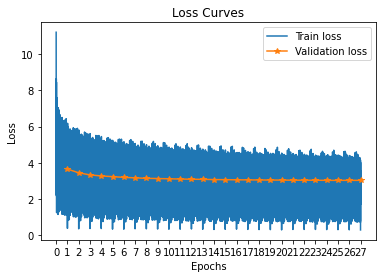

In [15]:
# Plotting loss curves:
if finished_at is None:
    finished_at = epochs

train_points = np.linspace(start=0,stop=finished_at,num=len(train_losses))
val_points = np.linspace(1, finished_at, finished_at).astype(int)
plt.plot(train_points,train_losses)
plt.plot(val_points,val_losses,marker='*')
plt.legend(["Train loss", "Validation loss"])
plt.xticks(np.arange(finished_at+1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.show()

## Compute topical distributions using a Latent Dirichlet allocation model:

In [11]:
class LDA():

    def __init__(self, dataset, tokenizer, n_components, max_iter, max_features):
        self.dataset = dataset
        self.n_components = n_components
        self.tokenizer = tokenizer

        self.tf_vectorizer = CountVectorizer(max_features=len(tokenizer),
                                        stop_words="english")
        
        self.lda = LatentDirichletAllocation(
            n_components=n_components, # number of topics
            learning_method="online",  # faster training by using the "online" algorithm
            max_iter=max_iter,         # number of epochs
            random_state=0,            # random seed for reproducibility
            n_jobs=-1,                 # uses all available CPU cores
            verbose=1                  # shows some output during training
            )
        
        # Train the LDA model:
        self.fit_lda()
        # Create dictionary of topic distributions:        
        # self.create_topic_dict()

    def fit_lda(self):
        print("Training the LDA model: ")
        raw_texts = self.dataset.get_all_texts()
        doc_matrix = self.tf_vectorizer.fit_transform(raw_texts)
        t0 = time.time()
        self.lda.fit(doc_matrix)
        print(f"Model trained in {time.time()-t0:.3f} seconds.")

    def compute_topic_distributions(self, word):
        '''
        Creates a dictionary of topic distributions for all words in the vocabulary.
        '''
        # Transform the word to vector:
        vectorized_word = self.tf_vectorizer.transform([word])
        # Compute topic distribution
        topic_dist = self.lda.transform(vectorized_word)
        # Return the probabilities:
        return topic_dist[0].tolist()

    def create_topic_dict(self):
        '''
        Create dictionary of topic distributions. In the case of two topics,
         every word in the vocabulary will have an entry such that:
         word : [p(topic_1 | word), p(topic_2 | word)]
        '''
        self.topic_dict = {word: self.compute_topic_distributions(word) for word in self.tokenizer.vocab}
        t0 = time.time()
        print(f'Topic distribution dictinary created in {time.time()-t0} seconds')

    def plot_top_words(self, n_top_words=50):
        '''
        Method for visualizing the top words belonging to each topic.
        '''
        feature_names = self.tf_vectorizer.get_feature_names_out()
        n_cols = self.n_components
        n_rows = ceil(self.n_components/n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharex=True)
        axes = axes.flatten()
        for topic_idx, topic in enumerate(self.lda.components_):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 14})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=10)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)

        plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
        plt.show()

    def get_dict(self):
        '''
        Getter for the topic distribution dictionary
        '''
        return self.topic_dict

Training the LDA model: 
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Model trained in 151.402 seconds.
Topic distribution dictinary created in 7.152557373046875e-07 seconds


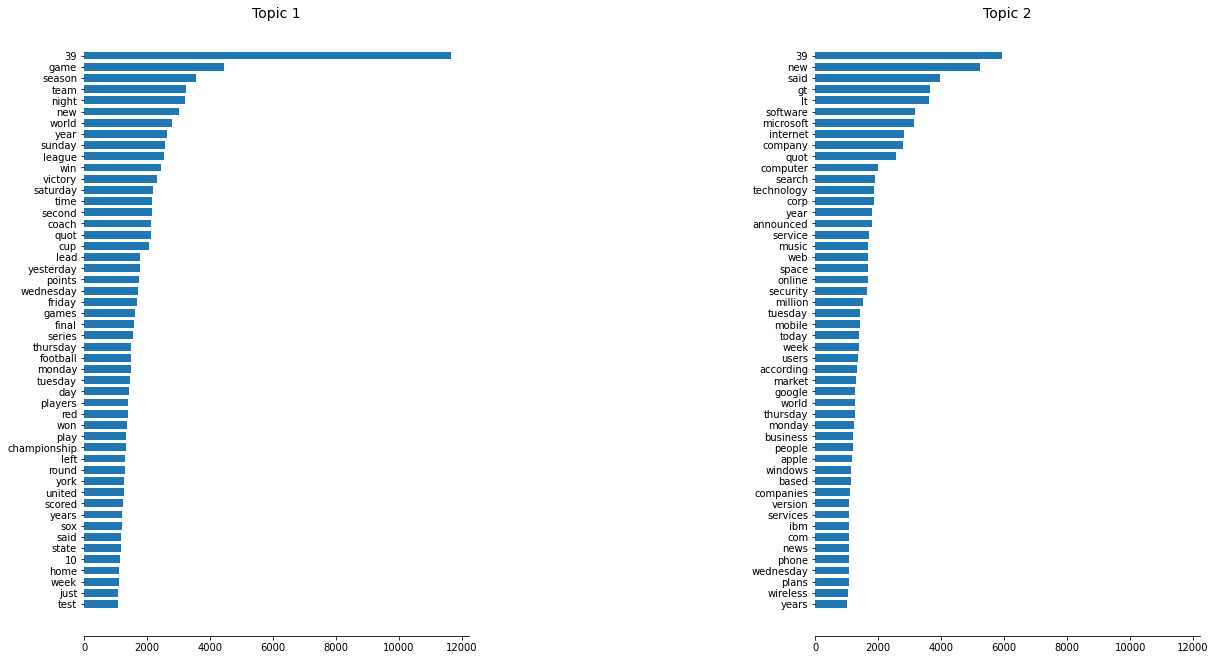

In [12]:
# Setting up the LDA-model:

lda = LDA(dataset=news_dataset, # The dataset we constructed initially
          tokenizer=tokenizer, # The pre-trained tokenizer we have been using
          n_components=2, # Number of topics. We have been using 2 so far.
          max_iter=10, # Number of training iterations of the model.
          max_features=len(tokenizer) # In this case, we are using the size of the complete vocabulary (don't know if this is necessary?)
          )

# Creating topic distribution dictionary:
lda.create_topic_dict()
topic_dict = lda.get_dict()
lda.plot_top_words()

## Generating the text:

In [13]:
def generate_text(prompt, n_tokens, n_sentences=1, model=best_model, topic=0,temp=1, gamma=1, topic_dict=topic_dict, tokenizer=tokenizer):
    '''
      Function for generating text using the trained model and the computed topic
      distributions.
    '''
    all_texts = []
    tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].to(device)
    
    for i in range(n_sentences):
        generated_tokens = model.generate(
            prompt = tokenized_prompt.reshape(-1,1),
            length = n_tokens,
            temp = temp,
            topic = topic,
            topic_dict = topic_dict,
            gamma = 1
            )
        decoded_text = tokenizer.decode(generated_tokens.flatten().tolist(), skip_special_tokens=True)

        print(decoded_text)
        all_texts.append(decoded_text)
    return all_texts

In [31]:
_ = generate_text(prompt='The',
              n_tokens=50,
              n_sentences=3,
              model=best_model,
              topic=0,
              temp=1,
              gamma=1,
              topic_dict=topic_dict,
              tokenizer=tokenizer)

The curl and image of a strict cap on SI International Space Station (ISS) across the globe totaled nearly two years that would almost have become the first nation. By genetically engineered grasshoithere in the way the going to pick up with two years as
The San Diego Padres, a new head coach Darrell Dunn after departed Lehman will lead the former Los Angeles Dodgers, reaching the Chicago Cubs and an 86-83 loss on Friday night.
The Carolina Panthers #39; game Saturday.
